In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler

In [16]:
csv_path = "../data/subdataset.csv"
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(1460, 15)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,250000


In [17]:
# 1. Price per m^2

df['LotArea_m^2'] = df['LotArea']*0.092903
df['Price_per_m^2'] = df['SalePrice'] / df['LotArea_m^2']

- A	Agriculture
- C	Commercial
- **FV	Floating Village Residential**
- I	Industrial
- **RH	Residential High Density**
- **RL	Residential Low Density**
- RP	Residential Low Density Park 
- **RM	Residential Medium Density**

In [18]:
# 2. Property Development index ( PDI )
scaler = MinMaxScaler()
df['MSZoning'].value_counts()


MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [19]:
zoning_mean_price = df.groupby('MSZoning')['SalePrice'].mean().round(2)
print(zoning_mean_price)

MSZoning
C (all)     74528.00
FV         214014.06
RH         131558.38
RL         191004.99
RM         126316.83
Name: SalePrice, dtype: float64


In [20]:
df['ZoningScore'] = df['MSZoning'].map(zoning_mean_price)
df['ZoningScore'] = scaler.fit_transform(df[['ZoningScore']])

df[['MSZoning', 'SalePrice', 'ZoningScore']].head(10)
                                                  

,MSZoning,SalePrice,ZoningScore
0,RL,208500,0.835044
1,RL,181500,0.835044
2,RL,223500,0.835044
3,RL,140000,0.835044
4,RL,250000,0.835044
5,RL,143000,0.835044
6,RL,307000,0.835044
7,RL,200000,0.835044
8,RM,129900,0.371283
9,RL,118000,0.835044


In [21]:
df['SubClassScore'] = df['MSSubClass'] / 190
df['LotAreaNorm'] = scaler.fit_transform(df[['LotArea']])
df['PDI'] = (
    0.4 * df['ZoningScore'] + 
    0.3 * df['SubClassScore'] + 
    0.3 * df['LotAreaNorm']
)

In [22]:
# 3. Economic Value Index
df['Price_per_m^2_norm'] = scaler.fit_transform(df[['Price_per_m^2']])
df['EVI'] = (
    0.5 * df['Price_per_m^2_norm'] +
    0.3 * df['ZoningScore'] +
    0.2 * df['SubClassScore']
)

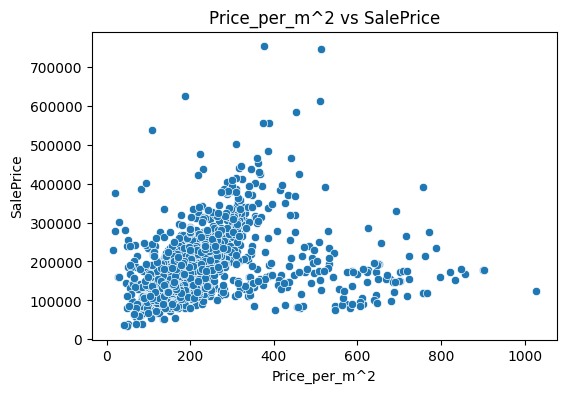

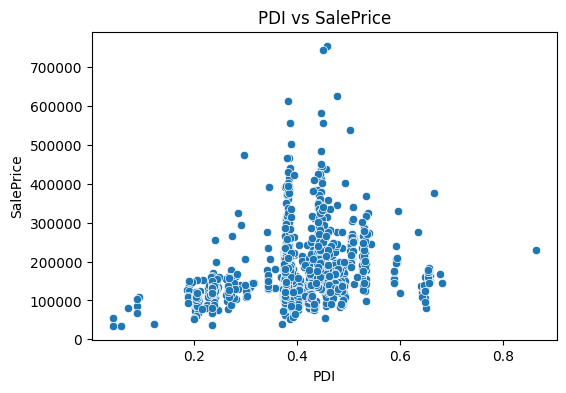

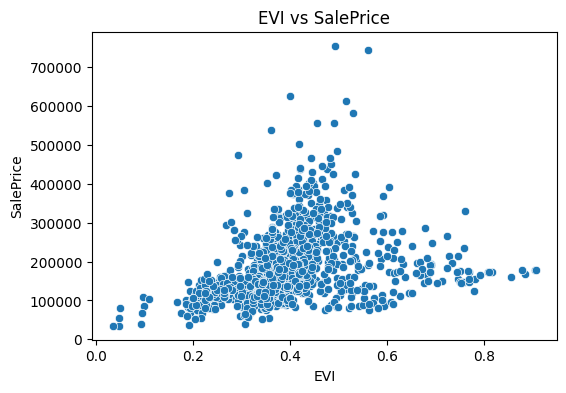

SalePrice        1.000000
EVI              0.310878
Price_per_m^2    0.273401
PDI              0.252049
Name: SalePrice, dtype: float64


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Price_per_m^2', 'PDI', 'EVI']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df['SalePrice'])
    plt.title(f"{feature} vs SalePrice")
    plt.xlabel(feature)
    plt.ylabel("SalePrice")
    plt.show()

corrs = df[features + ['SalePrice']].corr()
print(corrs['SalePrice'].sort_values(ascending=False))


## New Engineered Features

### 1. Price_per_m2  
Formula:  
Price_per_m2 = SalePrice / LotArea (m²)  

Măsoară valoarea terenului per metru pătrat.  
Valori mari indică proprietăți aflate în zone scumpe sau moderne,  
iar valori mici indică terenuri mari sau zone periferice.

---

### 2. Property Development Index (PDI)  
Formula:  
PDI = 0.4 × ZoningScore_norm + 0.3 × SubClassScore_norm + 0.3 × (1 - LotAreaNorm_norm)  

Combină informații despre zonă, tipul construcției și dimensiunea terenului.  
Valori mari sugerează proprietăți moderne, urbane; valori mici – zone rurale sau case vechi.

---

### 3. Economic Value Index (EVI)  
Formula:  
EVI = 0.5 × Price_per_m2_norm + 0.3 × ZoningScore_norm + 0.2 × SubClassScore_norm  

Reflectă valoarea economică totală a locuinței, combinând prețul pe m², densitatea zonei și tipul construcției.  
Valori mari indică proprietăți valoroase în zone bune; valori mici – proprietăți ieftine sau slab urbanizate.

---


In [24]:
df[['Price_per_m^2', 'PDI', 'EVI']].describe().round(2)


,Price_per_m^2,PDI,EVI
count,1460.00,1460.00,1460.00
mean,226.79,0.41,0.39
std,133.34,0.09,0.10
min,14.97,0.04,0.03
25%,148.27,0.38,0.34
50%,192.21,0.40,0.38
75%,255.85,0.45,0.43
max,1026.71,0.86,0.91


In [27]:
df.to_csv("../data/Cornescu_Darius_new_features.csv", index=False)
